# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [2]:
import os
import gc
import datetime
import numpy as np
import pandas as pd
import cv2
import sys
from PIL import Image

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from keras import backend as K
from keras.utils import Sequence
from keras_tqdm import TQDMNotebookCallback

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')
    
# getcwd -> current working directory
# path.basename -> take the file name that we inside

from libs.pconv_model import PConvUnet
from libs.util import MaskGenerator

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = "D:/School n Stuff/3.2 BAHAR/Inpainting Project/Places Dataset/places36k/train/"
VAL_DIR = "D:/School n Stuff/3.2 BAHAR/Inpainting Project/Places Dataset/places36k/validation/"
TEST_DIR = "D:/School n Stuff/3.2 BAHAR/Inpainting Project/Places Dataset/places36k/test/"

BATCH_SIZE = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating train & test data generator

In [21]:
class AugmentingDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, mask_generator, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)        
        seed = None if 'seed' not in kwargs else kwargs['seed']
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample            
            mask = np.stack([
                mask_generator.sample(seed)
                for _ in range(ori.shape[0])], axis=0
            )

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            

# Create training generator
train_datagen = AugmentingDataGenerator(  
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    MaskGenerator(256, 256, 3),
    target_size=(256, 256), 
    batch_size=BATCH_SIZE
)

# Create validation generator
val_datagen = AugmentingDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, 
    MaskGenerator(256, 256, 3), 
    target_size=(256, 256), 
    batch_size=BATCH_SIZE, 
    seed=42
)

# Create testing generator
test_datagen = AugmentingDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    MaskGenerator(256, 256, 3), 
    target_size=(256, 256), 
    batch_size=BATCH_SIZE, 
    seed=42
)

Found 6083 images belonging to 1 classes.


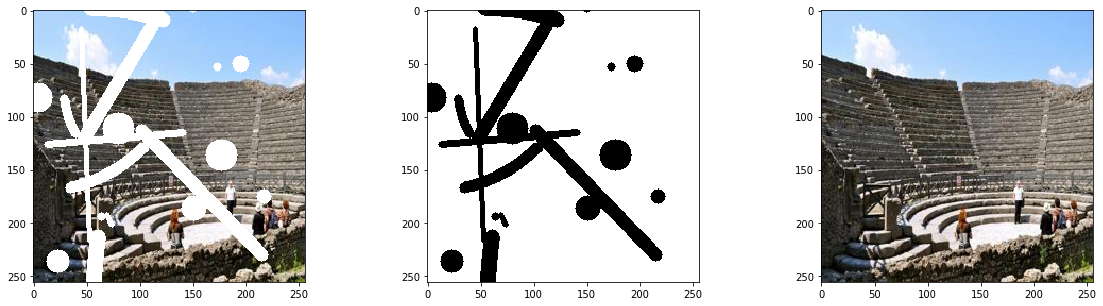

In [22]:
sys.modules['Image'] = Image 

# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

Found 6083 images belonging to 1 classes.


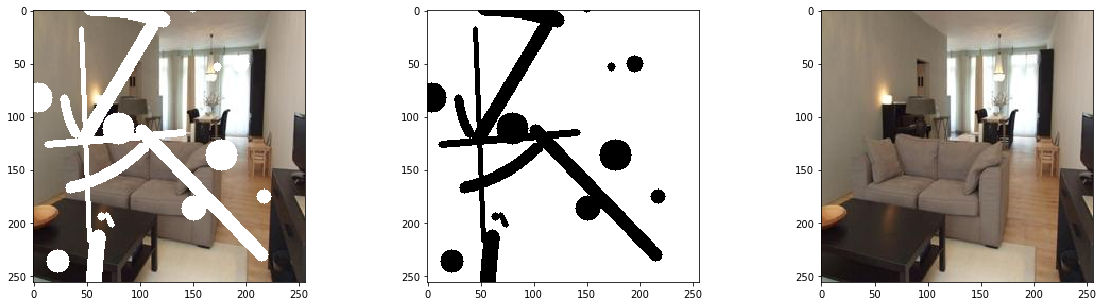

In [24]:
sys.modules['Image'] = Image 

val_data = next(val_generator)
(masked, mask), ori = val_data
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on ImageNet

In [4]:
FOLDER = 'D:/School n Stuff/3.2 BAHAR/Inpainting Project/Methods/Partial Convolutions/test_samples/'
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(FOLDER + 'img_{}_{}.png'.format(i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [25]:
model = PConvUnet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_33 (PConv2D)           [(None, 128, 128, 64 9472        inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 128, 128, 64) 0           p_conv2d_33[0][0]                
__________

__________________________________________________________________________________________________
up_sampling2d_46 (UpSampling2D) (None, 128, 128, 128 0           p_conv2d_46[0][1]                
__________________________________________________________________________________________________
concatenate_45 (Concatenate)    (None, 128, 128, 192 0           activation_17[0][0]              
                                                                 up_sampling2d_45[0][0]           
__________________________________________________________________________________________________
concatenate_46 (Concatenate)    (None, 128, 128, 192 0           p_conv2d_33[0][1]                
                                                                 up_sampling2d_46[0][0]           
__________________________________________________________________________________________________
p_conv2d_47 (PConv2D)           [(None, 128, 128, 64 110656      concatenate_45[0][0]             
          

In [ ]:
FOLDER = 'D:/School n Stuff/3.2 BAHAR/Inpainting Project/Methods/Partial Convolutions/logs'

# Run training for certain amount of epochs
model.fit_generator(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=1000,
    epochs=50,  
    verbose=0,
    callbacks=[
        TensorBoard(
            log_dir=FOLDER,
            write_graph=False
        ),
        ModelCheckpoint(
            FOLDER+'weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        ),
        TQDMNotebookCallback()
    ]
)